In [2]:
'''
Import necessary packages
'''
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import imageio
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from PIL import Image
# import cv2
from collections import Counter

np.set_printoptions(precision=3)

%matplotlib inline

In [3]:
'''
Define the color card with ISCC_NBS
'''

# Read ISCC from local file
path_iscc = os.path.join('ISCC_NBS', 'ISCC_NBS_w3.csv')
df_iscc = pd.read_csv(path_iscc, names = ['color_name', 'hex'])

# Get the RGB and CIE-Lab values for each color in ISCC color card
df_iscc['RGB'] = ""
df_iscc['Lab'] = ""
for index, row in df_iscc.iterrows(): 
    df_iscc.loc[index, 'RGB'] = sRGBColor.new_from_rgb_hex(row['hex'])
    df_iscc.loc[index, 'Lab'] = convert_color(df_iscc.loc[index, 'RGB'], LabColor).get_value_tuple()

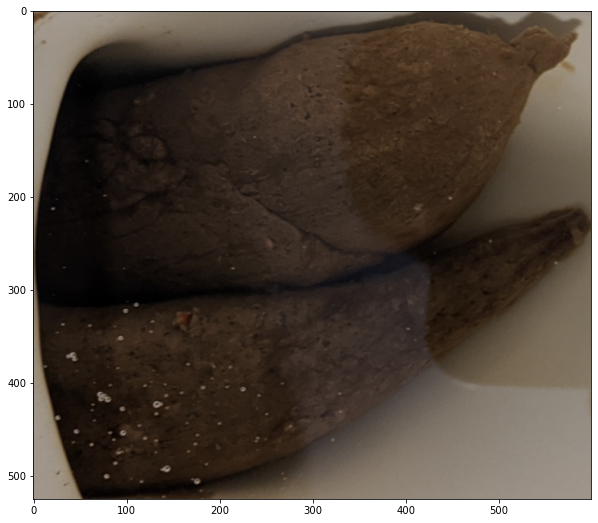

In [6]:
'''
Read and show the test image
'''
path_img = os.path.join('images', 'good', 'crowdsourcing_00001.png')
img = Image.open(path_img).convert('RGB')
img = np.array(img)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

In [7]:
img.shape

(525, 600, 3)

In [8]:
def convert_to_lab(arr_rgb):
    '''
    This function will transform every rgb value in the list to lab. 
    '''
    
    list_lab = []
    for row in arr_rgb:
        r, g, b = row
        list_lab.append(convert_color(sRGBColor(r, g, b, is_upscaled=True), LabColor).get_value_tuple())
    return np.array(list_lab)


def convert_to_rgb(arr_lab):
    '''
    This function will transform every rgb value in the list to lab. 
    '''
    
    list_rgb = []
    for row in arr_lab:
        l, a, b = row
        list_rgb.append(convert_color(LabColor(l, a, b), sRGBColor).get_value_tuple())
    return np.array(list_rgb)

In [9]:
def find_the_cloeset_iscc(arr_img_lab, arr_iscc_lab):
    
    return arr_iscc_lab[np.argmin(cdist(arr_img_lab, arr_iscc_lab), 1)] 
      

In [10]:
arr_img_lab = convert_to_lab(img.reshape(img.shape[0]*img.shape[1], 3))
arr_iscc_lab = np.array(df_iscc['Lab'].tolist())
quantized_img_lab = find_the_cloeset_iscc(arr_img_lab, arr_iscc_lab)

In [8]:
quantized_img_rgb = convert_to_rgb(quantized_img_lab).reshape(img.shape[0], img.shape[1], 3)

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(quantized_img_rgb)
plt.show()

In [12]:
background_lab = np.array([95.7931405 , -0.15465805, -0.6054342])
(unique, counts) = np.unique(quantized_img_lab, return_counts=True, axis=0)
indices = np.argsort(counts)[::-1]
dict_color_count = {}
dict_color_name = {}


for i in indices:
    if cdist(unique[i].reshape(1, 3), background_lab.reshape(1, 3)) < 0.001:
        continue
    index_iscc = np.where(cdist(df_iscc['Lab'].tolist(), unique[i].reshape(1, 3))<0.01)
    hex_value = df_iscc.loc[index_iscc[0][0], 'hex']
    color_name = df_iscc.loc[index_iscc[0][0], 'color_name']
    dict_color_count[hex_value] = counts[i]
    dict_color_name[hex_value] = color_name


In [13]:
count_sum = sum(dict_color_count.values())
dict_dominant_color_count = {color: count for color, count in dict_color_count.items() if count/count_sum > 0.01}
dict_dominant_color_count

{'#28201C': 91306,
 '#3E322C': 33417,
 '#3B3121': 28841,
 '#8E8279': 28657,
 '#222222': 25028,
 '#7E6D5A': 22949,
 '#4B3621': 22388,
 '#483C32': 16364,
 '#635147': 11499,
 '#8A8776': 7791,
 '#422518': 7690,
 '#958070': 4229,
 '#57554C': 3480,
 '#5B5842': 2649,
 '#242124': 2349,
 '#282022': 1317,
 '#AE9B82': 1281,
 '#5B504F': 1258,
 '#6F4E37': 1219,
 '#25241D': 557,
 '#8C8767': 404,
 '#826644': 146,
 '#5C504F': 66,
 '#2E1D21': 24,
 '#593319': 19,
 '#654522': 17,
 '#3E1D1E': 15,
 '#674C47': 9,
 '#43302E': 7,
 '#555555': 6,
 '#363527': 5,
 '#977F73': 4,
 '#A18F60': 3,
 '#848482': 3,
 '#403D21': 2,
 '#1E2321': 1}

In [14]:
dominant_hex_values = list(dict_dominant_color_count.keys())
dominant_color_counts = list(dict_dominant_color_count.values())
dominant_color_names= [dict_color_name[hex_value] for hex_value in dominant_hex_values]

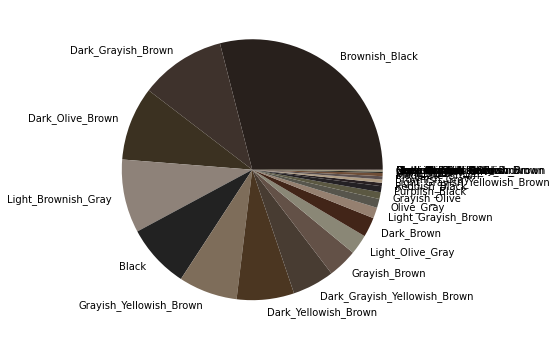

In [15]:
plt.figure(figsize = (8, 6))
plt.pie(dominant_color_counts, labels = dominant_color_names, colors = dominant_hex_values)
plt.show()

In [16]:
len(dominant_color_counts)

36

In [17]:
# function to return key for any value 
def get_key(my_dict, val): 
    for key, value in my_dict.items(): 
         if val == value: 
                return key 
    return "key doesn't exist"

In [18]:
def count_concerning_color(dominant_color_names, dict_color_count, concern_color = 'red'):
    count = 0
    color_concerns = []
    for color_name in dominant_color_names:
        if concern_color in color_name:
            color_hex = get_key(dict_color_name, color_name)
            count += dict_dominant_color_count[color_hex]
            color_concerns.append(color_name)
    count_sum = sum(dict_dominant_color_count.values())
    return color_concerns, count, count/count_sum

#     print(sum_red/count_sum)

In [19]:
count_concerning_color(dominant_color_names, dominant_color_counts,  'Red')

(['Reddish_Black',
  'Dark_Reddish_Gray',
  'Blackish_Red',
  'Dark_Reddish_Brown',
  'Grayish_Reddish_Brown',
  'Dark_Grayish_Reddish_Brown',
  'Light_Grayish_Reddish_Brown'],
 1442,
 0.004577777777777778)

In [20]:
count_concerning_color(dominant_color_names, dominant_color_counts, concern_color = 'Black')

(['Brownish_Black',
  'Black',
  'Purplish_Black',
  'Reddish_Black',
  'Olive_Black',
  'Blackish_Red',
  'Greenish_Black'],
 120582,
 0.3828)

In [21]:
arr_img_lab.shape

(315000, 3)

In [22]:
from sklearn.cluster import KMeans
from collections import Counter
def get_colors(arr_img, number_of_colors, show_chart=True):    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(arr_img)
    counts = Counter(labels)
    
    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    return counts, ordered_colors


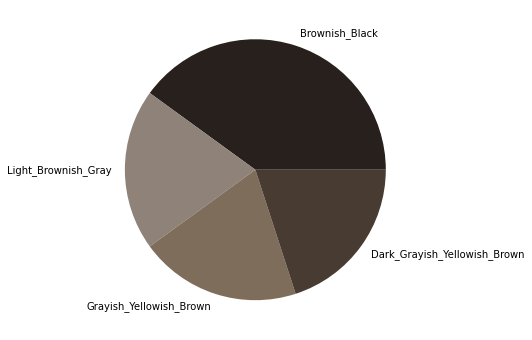

In [23]:
counts, ordered_colors = get_colors(arr_img_lab, number_of_colors = 5, show_chart=True)
k_means_lab =  find_the_cloeset_iscc(ordered_colors, arr_iscc_lab)

# k_means_rgb = convert_to_rgb(k_means_lab)*255
# k_means_hex = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]

(unique, counts) = np.unique(k_means_lab, return_counts=True, axis=0)
indices = np.argsort(counts)[::-1]
dict_color_count = {}
dict_color_name = {}


for i in indices:
    if cdist(unique[i].reshape(1, 3), background_lab.reshape(1, 3)) < 0.001:
        continue
    index_iscc = np.where(cdist(df_iscc['Lab'].tolist(), unique[i].reshape(1, 3))<0.01)
    hex_value = df_iscc.loc[index_iscc[0][0], 'hex']
    color_name = df_iscc.loc[index_iscc[0][0], 'color_name']
    dict_color_count[hex_value] = counts[i]
    dict_color_name[hex_value] = color_name
    
k_hex_values = list(dict_color_count.keys())
k_color_counts = list(dict_color_count.values())
k_color_names= [dict_color_name[hex_value] for hex_value in k_hex_values]
    
plt.figure(figsize = (8, 6))
plt.pie(k_color_counts, labels = k_color_names, colors = k_hex_values)
plt.show()

In [ ]:
arr_img_lab.shape

In [10]:
len(ordered_colors)

NameError: name 'ordered_colors' is not defined

In [ ]:
len(dict_color_name)